In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# enablers
%matplotlib inline

In [20]:
class Simple3DMarkovModel(object):
    def __init__(self, df, N):
        self._data = df.copy()
        self._intervals = [np.linspace(np.min(df[name]), np.max(df[name]), N)[1:]
                          for name in self._data.columns[:-1]]
        self._N = N
        
    def _get_encoder(self, dim):
        def encoder(pt):
            idx = 0
            for upper_bound in self._intervals[dim]:
                #import pdb; pdb.set_trace()
                if pt < upper_bound:
                    return idx
                idx += 1
            return idx
        return encoder
    
    def build(self):
        cols = self._data.columns
        for i in range(len(cols)-1):
            self._data[cols[i]] = self._data[cols[i]].apply(self._get_encoder(i))
        
        cord_map = dict()
        trans_matrix = dict()
        stat_prob = dict()
        loop_records = list()
        seen_set = set()
        
        prev_cord = tuple(df.iloc[0][:-1])
        prev_key = 0
        key_idx = 1
        cord_map[prev_cord] = prev_key
        stat_prob[prev_key] = 1
        for idx in range(1, len(self._data)):
            cur_cord = tuple(self._data.iloc[idx][:-1])
            if cur_cord == prev_cord:
                continue
            
            cur_key = -1
            if cur_cord in cord_map:
                cur_key = cord_map[cur_cord]
            else:
                cur_key = key_idx
                cord_map[cur_cord] = cur_key
                key_idx += 1
            
            trans_matrix[(prev_key, cur_key)] = trans_matrix.get((prev_key, cur_key), 0) + 1
            stat_prob[cur_key] = stat_prob.get(cur_key, 0) + 1
            prev_key = cur_key
            prev_cord = cur_cord
        
        new_loop = True
        loop_start_idx = 0
        seen_set.add(tuple(self._data.iloc[0][:-2]))
        for idx in range(1, len(df)):
            cord = tuple(self._data.iloc[idx][:-2])
            if new_loop:
                if cord not in seen_set:
                    seen_set.add(cord)
                    new_loop = False
            else:
                if cord not in seen_set:
                    seen_set.add(cord)
                else:
                    loop_records.append( (loop_start_idx, idx) )
                    
                    new_loop = True
                    loop_start_idx = idx
                    
                    seen_set.clear()
                    seen_set.add(cord)
                    
        stat_prob = pd.DataFrame(stat_prob.items(), columns=['node', 'prob'])
        stat_prob['prob'] = stat_prob['prob'] / stat_prob['prob'].sum()
        
        return (loop_records, cord_map, stat_prob,
                pd.DataFrame([(key[0], key[1], val) for key, val in trans_matrix.items()],
                            columns=['from', 'to', 'count'])
                )

In [3]:
df = pd.read_csv(os.path.join('simulation data', 'output_R1740_1430123192.csv'))

In [4]:
from math import log
def entropy(df):
    total = df['count'].sum()
    ent = 0.0
    for p in df['count'] / total:
        ent += -p * log(p, 2)
    return ent

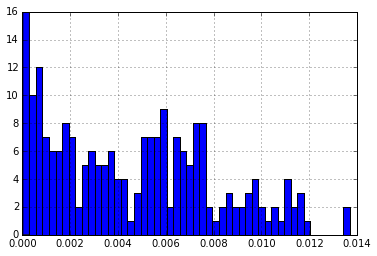

In [42]:
import json
N = 10
step = 10
with open("test_result.csv", "a", 0) as f:
    while N <= 20:
        mc = Simple3DMarkovModel(df, N)
        loop_records, cord_map, stat_prob, trans_df = mc.build()

        stat_prob.sort_index()
        ents = trans_df.groupby('from').apply(entropy).sort_index()
        ent_rate = ents[ents > 0.0] * stat_prob['prob'][ents > 0.0]
        ent_rate = ent_rate.sum()
        
        f.write(json.dumps([N, ent_rate.item(), stat_prob['prob'].tolist(), [e[1] - e[0] for e in loop_records] ]) + '\n')
        f.flush()
        print 'N=%d done' % N
        
        N += step

N=10 done
N=20 done
